In [1]:
import numpy as np
import qiskit
import qiskit_aer
import qiskit.visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime
mpl.rcParams.update(mpl.rcParamsDefault)

In [3]:
import qiskit_ibm_provider
ibmprovider = qiskit_ibm_provider.IBMProvider(token="9e027ffd514fe6fe384a7c915db815287e72104e52daca921f8d7854d6362b39a127bad928fb2ddad1d85bf7434306ca01b5496e7fab340eef01b815df13d45f", instance="ibm-q/open/main")
backend_sherbrooke = ibmprovider.get_backend('ibm_sherbrooke')
backend_kyoto = ibmprovider.get_backend('ibm_kyoto')

ModuleNotFoundError: No module named 'qiskit_ibm_provider'

In [2]:
from qiskit_ibm_runtime.fake_provider import FakePerth
fakebackend = FakePerth()

In [3]:
def circmake(probe,groups,points,backend):
    
    circs=[] 
    j = 0
    
    while j <groups:
        i = 0
        while i<points:
        
            circ = qiskit.QuantumCircuit(qiskit.QuantumRegister(1, name="Meter_Z"),
                      qiskit.QuantumRegister(1, name="System"),
                      qiskit.QuantumRegister(1, name="Probe_X"),
                      qiskit.QuantumRegister(1, name="Probe_Z"),
                      qiskit.ClassicalRegister(4, name="readout"))

            mez=np.arccos(0.0+1/(points-1)*i)

            circ.rz(-np.pi,1)
            circ.sx(1)
            circ.rz(-np.pi,1)
            circ.barrier()

            circ.rz(-np.pi,3)
            circ.sx(3)
            circ.rz(np.pi-np.arccos(probe),3)
            circ.sx(3)

            circ.cx(1,3)

            circ.barrier()
            circ.rz(np.pi/2,1)
            circ.sx(1)
            circ.rz(np.pi/2,1)

            circ.rz(-np.pi,2)
            circ.sx(2)
            circ.rz(np.pi-np.arccos(probe),2)
            circ.sx(2)

            circ.cx(1,2)

            circ.rz(np.pi/2,1)
            circ.sx(1)
            circ.rz(np.pi/2,1)

            circ.barrier()
            circ.rz(-np.pi,0)
            circ.sx(0)
            circ.rz(np.pi-mez,0)
            circ.sx(0)

            circ.cx(1,0)


            circ.barrier()
            circ.rz(np.pi/2,1)
            circ.sx(1)
            circ.rz(np.pi/2,1)
    
            circ.measure([0,1,2,3],[1,0,2,3])
            circ=qiskit.compiler.transpile(circ,backend=backend,optimization_level=1)
            circs.append(circ)
            i += 1
        j+= 1
    
    return circs

In [4]:
def make_noise_model(prob_1=None,prob_2=None,prob_r=None):
    cnoise_model = qiskit_aer.noise.NoiseModel(basis_gates=['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x'])
    
    if prob_1:
        error_1 = qiskit_aer.noise.depolarizing_error(prob_1, 1)
        cnoise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x',"id"])
    
    if prob_2:
        error_2 = qiskit_aer.noise.depolarizing_error(prob_2, 2)
        cnoise_model.add_all_qubit_quantum_error(error_2, ['cx'])
    
    if prob_r:
        error_r = qiskit_aer.noise.ReadoutError(prob_r)
        cnoise_model.add_all_qubit_readout_error(error_r)
    
    return cnoise_model

In [ ]:
def adjust_backend_noise_model(backend, phase=0, amplitude=0):
    qnoise_model = qiskit_aer.noise.NoiseModel.from_backend(backend,temperature=50)
    error_1 = qiskit_aer.noise.phase_amplitude_damping_error(phase, amplitude)
    
    m = backend.num_qubits
    for n in np.linspace(0, m - 1, m, dtype=int) :
        qnoise_model.add_quantum_error(error_1, ['rz', 'sx', 'x',"id"], [n])
    del m
    return qnoise_model

In [24]:
def make_phase_amplitudead(phase=0, amplitude=0):
    cnoise_model = qiskit_aer.noise.NoiseModel(basis_gates=['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x'])
    error_1 = qiskit_aer.noise.phase_amplitude_damping_error(phase, amplitude)

    cnoise_model.add_all_qubit_quantum_error(error_1, ['rz', 'sx', 'x',"id"])

    return cnoise_model

In [6]:
def get_ed(raw):
    err_raw = qiskit.result.marginal_counts(raw,indices=[1,3]).get_counts()
    dis_raw = qiskit.result.marginal_counts(raw,indices=[0,2]).get_counts()
    error = np.zeros([groups,points])
    i = 0
    while i < groups:
        j = 0
        while j < points:
            a = (np.sqrt(2*abs(1-(err_raw[i*points+j]['00']+err_raw[i*points+j]['11']-err_raw[i*points+j]['01']-err_raw[i*points+j]['10'])/shots/0.1)))
            error[i][j] = a
            j += 1
        i += 1
    
    disturb = np.zeros([groups,points])
    i = 0
    while i < groups:
        j = 0
        while j < points:
            a = (np.sqrt(2*abs(1-(dis_raw[i*points+j]['00']+dis_raw[i*points+j]['11']-dis_raw[i*points+j]['01']-dis_raw[i*points+j]['10'])/shots/0.1)))
            disturb[i][j] = a
            j += 1
        i += 1
    return error.transpose(), disturb.transpose()

In [7]:
def get_plot_data(raw_error,raw_disturb,points):
    result = np.zeros([4,points]) 
    i = 0
    while i <points :
        result[0,i]= (np.sum(raw_error[i])-np.max(raw_error[i])-np.min(raw_error[i]))/(groups-2)
        result[2,i]= (np.sum(raw_disturb[i])-np.max(raw_disturb[i])-np.min(raw_disturb[i]))/(groups-2)
        #result[0,i]= np.mean(raw_error[i])
        #result[2,i]= np.mean(raw_disturb[i])
        result[1,i]= np.std(raw_error[i],ddof=1)
        result[3,i]= np.std(raw_disturb[i],ddof=1)
        i += 1
    return result

In [8]:
def measurement_strength_plot(sim_result, points):
    E=np.linspace(0,1,1001)
    plt.figure(figsize=(15,10))
   
    strength1 = np.linspace(0.0,1.0,11)
    strength2 = np.linspace(0.0,1.0,points)

    plt.plot(E,np.sqrt(2*(1-E)),color='#0000de',lw=3,label='Theory')
    plt.plot(E,np.sqrt(2*(1-np.sin(np.arccos(E)))),color='#de0000',lw=3,label='Theory')

    plt.errorbar(strength1, exp_result[0], yerr=exp_result[1], elinewidth=1 ,color="b",fmt="^",ms=12,mec="b",capsize=5,capthick=2,label='QC')
    plt.errorbar(strength1, exp_result[2], yerr=exp_result[3], elinewidth=1 ,color="r",fmt="d",ms=12,mec="r",capsize=5,capthick=2,label='QC')

    plt.plot(strength2, sim_result[0][0], lw=3, ls="--" ,color="g",label='Simulation')
    plt.plot(strength2, sim_result[0][2], lw=3, ls="--" ,color="purple",label='Simulation')

    plt.errorbar(endata[0],endata[1], yerr=endata[3], elinewidth=1 ,color="#00b2b3",fmt="*",ms=12,mec="#00b2b3",capsize=5,capthick=2,label='Photon')
    plt.errorbar(endata[0],endata[2], yerr=endata[4], elinewidth=1 ,color="#e67300",fmt="s",ms=12,mec="#e67300",capsize=5,capthick=2,label='Photon')

    plt.legend(bbox_to_anchor=(0.87,-0.17),loc='upper right',fontsize=18,ncol=4)
    plt.xlabel("Measurement Strength (cos ${\\theta}$)",size=32,labelpad=24)
    plt.ylabel("Error and Disturbance",size=32,labelpad=18)
    plt.tick_params(labelsize=32)
    plt.grid(True)
    plt.show()


In [36]:
def error_simpling_plot(sim_result, points):
    E=np.linspace(0,1,1001)
    plt.figure(figsize=(15,10))
   
    strength1 = np.linspace(0.0,1.0,11)
    strength2 = np.linspace(0.0,1.0,points)

    plt.plot(E,np.sqrt(2*(1-E)),color='#0000de',lw=3,label='Theory')
    plt.plot(E,np.sqrt(2*(1-np.sin(np.arccos(E)))),color='#de0000',lw=3,label='Theory')

    plt.plot(strength2, sim_result[0][0], lw=3, ls=":" ,color="g",label='0.005')
    plt.plot(strength2, sim_result[0][2], lw=3, ls=":" ,color="purple",label='0.005')

    plt.plot(strength2, sim_result[1][0], lw=3, ls="-." ,color="g",label='0.01')
    plt.plot(strength2, sim_result[1][2], lw=3, ls="-." ,color="purple",label='0.01')


    plt.plot(strength2, sim_result[2][0], lw=3, ls="--" ,color="g",label='0.02')
    plt.plot(strength2, sim_result[2][2], lw=3, ls="--" ,color="purple",label='0.02')
    

    # plt.plot(np.sqrt(strength2), sim_result[3][0], lw=3, ls="--" ,color="g",label='10m')
    # plt.plot(np.sqrt(strength2), sim_result[3][2], lw=3, ls="--" ,color="purple",label='10m')

    #order = [0,1,3,5]
    #handles, labels = plt.gca().get_legend_handles_labels()
    #add legend to plot
    #plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],bbox_to_anchor=(0.87,-0.17),loc='upper right',fontsize=22,ncol=1) 
    #plt.legend(bbox_to_anchor=(0.97,-0.17),loc='upper right',fontsize=22,ncol=1)
    plt.legend(bbox_to_anchor=(0.87,-0.17),loc='upper right',fontsize=22,ncol=4)
    plt.xlabel("Measurement Strength (cos ${\\theta}$)",size=32,labelpad=24)
    plt.ylabel("Error and Disturbance",size=32,labelpad=18)
    plt.tick_params(labelsize=32)
    plt.grid(True)
    plt.show()

In [23]:
def measurement_strength_noise_compare_plot(sim_result, points):
    E=np.linspace(0,1,1001)
    plt.figure(figsize=(15,10))
   
    strength1 = np.linspace(0.0,1.0,11)
    strength2 = np.linspace(0.0,1.0,points)

    plt.plot(E,np.sqrt(2*(1-E)),color='#0000de',lw=3,label='Theory')
    plt.plot(E,np.sqrt(2*(1-np.sin(np.arccos(E)))),color='#de0000',lw=3,label='Theory')

    plt.plot(strength2, sim_result[0][0], lw=3, color="g",label='All')
    plt.plot(strength2, sim_result[0][2], lw=3, color="purple",label='All')

    plt.plot(strength2, sim_result[1][0], lw=3, ls="--" ,color="g",label='Depolarization')
    plt.plot(strength2, sim_result[1][2], lw=3, ls="--" ,color="purple",label='Depolarization')

    plt.plot(strength2, sim_result[2][0], lw=3, ls=":" ,color="g",label='Thermal Relaxation')
    plt.plot(strength2, sim_result[2][2], lw=3, ls=":" ,color="purple",label='Thermal Relaxation')

    plt.plot(strength2, sim_result[3][0], lw=3, ls="-." ,color="g",label='Readout')
    plt.plot(strength2, sim_result[3][2], lw=3, ls="-." ,color="purple",label='Readout')

    plt.legend(bbox_to_anchor=(0.87,-0.17),loc='upper right',fontsize=14,ncol=5)
    plt.xlabel("Measurement Strength (cos ${\\theta}$)",size=32,labelpad=24)
    plt.ylabel("Error and Disturbance",size=32,labelpad=18)
    plt.tick_params(labelsize=32)
    plt.grid(True)
    plt.show()

In [10]:
def forbidden_zone_plot(sim_result):
    plt.figure(figsize=(15,15))

    b = np.linspace(0.5,1.8,1000)
    c = np.linspace(0.001,1,1000)


    plt.errorbar(sim_result[0],sim_result[2], xerr=sim_result[1],yerr=sim_result[3], elinewidth=2 ,color="black",capsize=5,capthick=2,fmt="o",ms=12,mec="b")

    x = np.linspace(-2, 2, 1000)

    x = np.linspace(-2, 2, 1000)
    y = np.linspace(-2, 2, 1000)
    X, Y = np.meshgrid(x, y)


    Z = np.sqrt((X**2 - X**4/4) + (Y**2 - Y**4/4))


    plt.contourf(X, Y, Z, levels=[1, Z.max()], colors='y', alpha=0.22)


    plt.contour(X, Y, Z, levels=[1], colors='blue',linewidths=4,linestyles="--")
    plt.plot(c,(1-c)/(1+c),lw=4,color="black")

    plt.plot(b,1/b,lw=4,color="purple")

    plt.plot(c,np.sqrt(1-c*c),lw=4,color="r")



    plt.fill_between(c,(1-c)/(1+c),color="gray",alpha=0.3)
    plt.fill_between(c,(1-c)/(1+c),np.sqrt(1-c*c),color="b",alpha=0.3)
    plt.fill_between(b,1/b,999,color="w",alpha=1)
    plt.fill_between(b,1/b,999,color="g",alpha=0.4)
    plt.xlim(0,1.6)
    plt.ylim(0,1.6)

    #plt.legend(bbox_to_anchor=(0.97,-0.12),loc='upper right',fontsize=22,ncol=2)
    plt.xlabel("Error",size=32)
    plt.ylabel("Disturbance",size=32)
    plt.tick_params(labelsize=32)
    plt.show()

In [12]:
endata = np.array([[1, 0.286356421, 1.393197761, 0.10687, 0.01384],
                [0.985, 0.360555128, 1.286468033, 0.07454, 0.01746],
                [0.94, 0.498998998, 1.170042734, 0.05173, 0.02122],
                [0.866, 0.68556546, 1.069579357, 0.03524, 0.02645],
                [0.766, 0.80684571, 0.908845421, 0.02983, 0.02114],
                [0.643, 0.927900857, 0.797496081, 0.0284, 0.02203],
                [0.5, 1.105893304, 0.628490254, 0.03243, 0.04083],
                [0.342, 1.221474519, 0.559464029, 0.01564, 0.05626],
                [0.174, 1.354252561, 0.46151923, 0.0143, 0.05765],
                [0, 1.439791652, 0.354964787, 0.02433, 0.06816]])
endata = endata.transpose()
exp_result = np.array([[1.41552695,1.36435836,1.28781354,1.20447702,1.16895506,1.06177519,
                      1.01689894,0.88108358,0.74446709,0.68535111,0.56322395],
                        [0.01512828,0.03275893,0.03075678,0.02201124,0.0278425, 0.05022082,
                      0.05120571,0.06349935,0.07895512,0.10610931,0.13539114],
                        [0.65089794,0.58770411,0.61701889,0.70274453,0.71313554,0.78121456,
                      0.86118775,0.93261966,1.02441124,1.09042051,1.34376592],
                        [0.08422546,0.08669819,0.08041575,0.09286758,0.07725798,0.06533498,
                      0.06205029,0.0433318, 0.05103344,0.05436436,0.04136799]])

In [14]:
shots_lists = np.array([1000,10000,100000],dtype=int)
probe_strength = 0.1
groups = 10
points = 41

circs = circmake(probe_strength,groups,points,fakebackend)
noise_model = qiskit_aer.noise.NoiseModel(basis_gates=['cx', 'delay', 'id', 'measure', 'reset', 'rz', 'sx', 'x'])

sim_results = []
for shots in shots_lists:    
    sim_job = fakebackend.run(circs, noise_model = noise_model ,shots=shots).result()
    raw_error,raw_disturb = get_ed(sim_job)
    sim_results.append(get_plot_data(raw_error,raw_disturb,points))

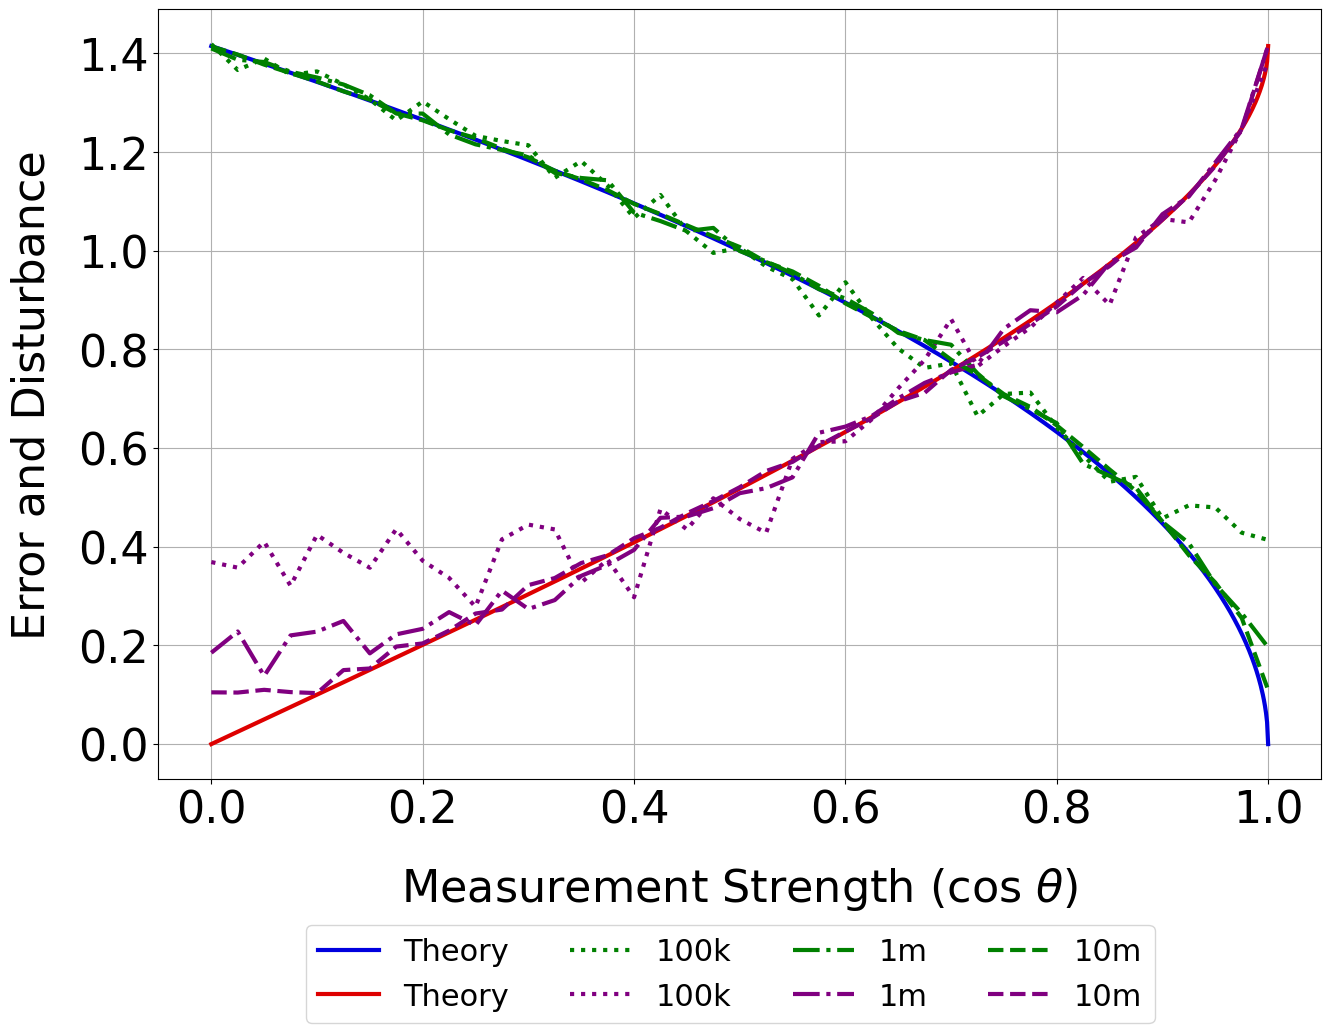

In [13]:
error_simpling_plot(sim_results, points)

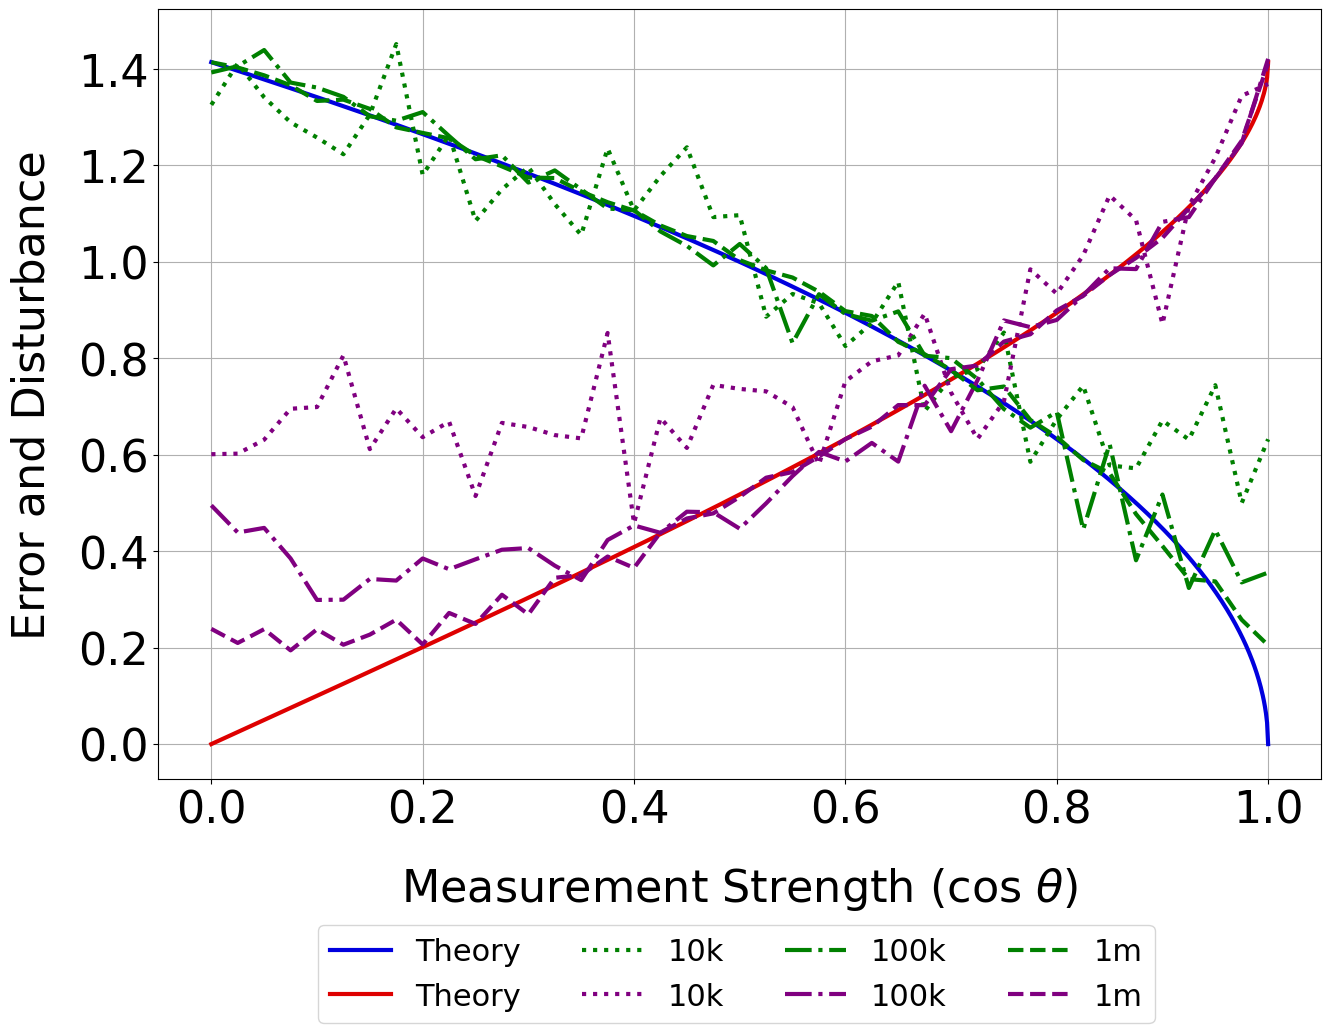

In [16]:
error_simpling_plot(sim_results, points)

In [13]:
probe_strength = 0.1
groups = 10
shots = 1000000
points = 21

circs = circmake(probe_strength,groups,points,fakebackend)

qnoise_model1 = qiskit_aer.noise.NoiseModel.from_backend(fakebackend,
                                                        gate_error=True,
                                                        readout_error=True,
                                                        thermal_relaxation=True,
                                                        temperature=50)
qnoise_model2 = qiskit_aer.noise.NoiseModel.from_backend(fakebackend,
                                                        gate_error=True,
                                                        readout_error=False,
                                                        thermal_relaxation=False,
                                                        temperature=0)
qnoise_model3 = qiskit_aer.noise.NoiseModel.from_backend(fakebackend,
                                                        gate_error=False,
                                                        readout_error=False,
                                                        thermal_relaxation=True,
                                                        temperature=50)
qnoise_model4 = qiskit_aer.noise.NoiseModel.from_backend(fakebackend,
                                                        gate_error=False,
                                                        readout_error=True,
                                                        thermal_relaxation=False,
                                                        temperature=0)

noise_model_list = [qnoise_model1,qnoise_model2,qnoise_model3,qnoise_model4]

sim_results = []
for noise_model in noise_model_list:
    
    sim_job = fakebackend.run(circs, noise_model = noise_model ,shots=shots).result()
    raw_error,raw_disturb = get_ed(sim_job)
    sim_results.append(get_plot_data(raw_error,raw_disturb,points))

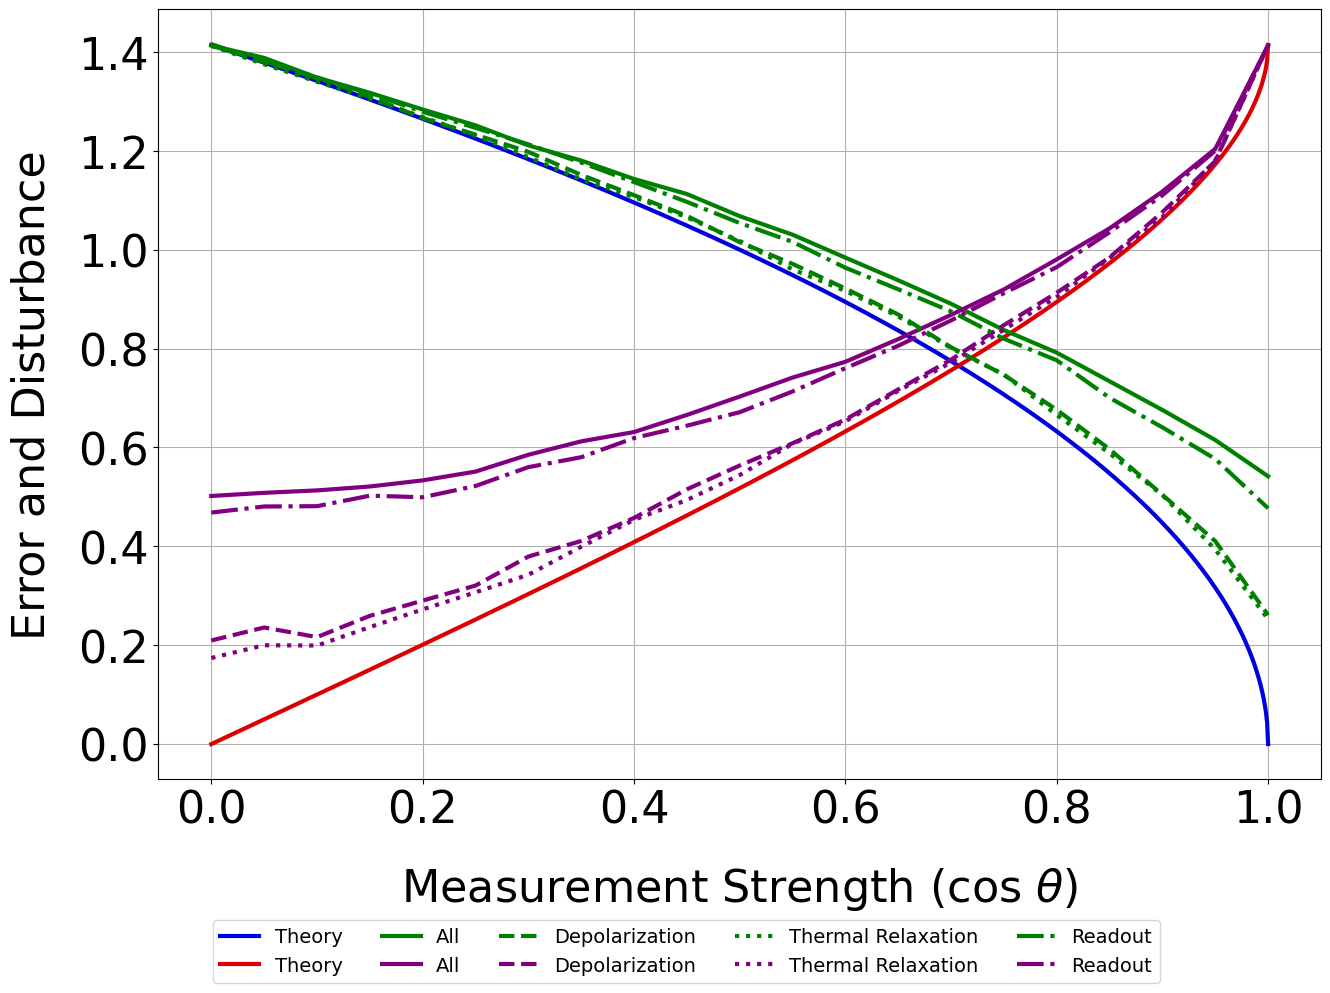

In [24]:
measurement_strength_noise_compare_plot(sim_results, points)

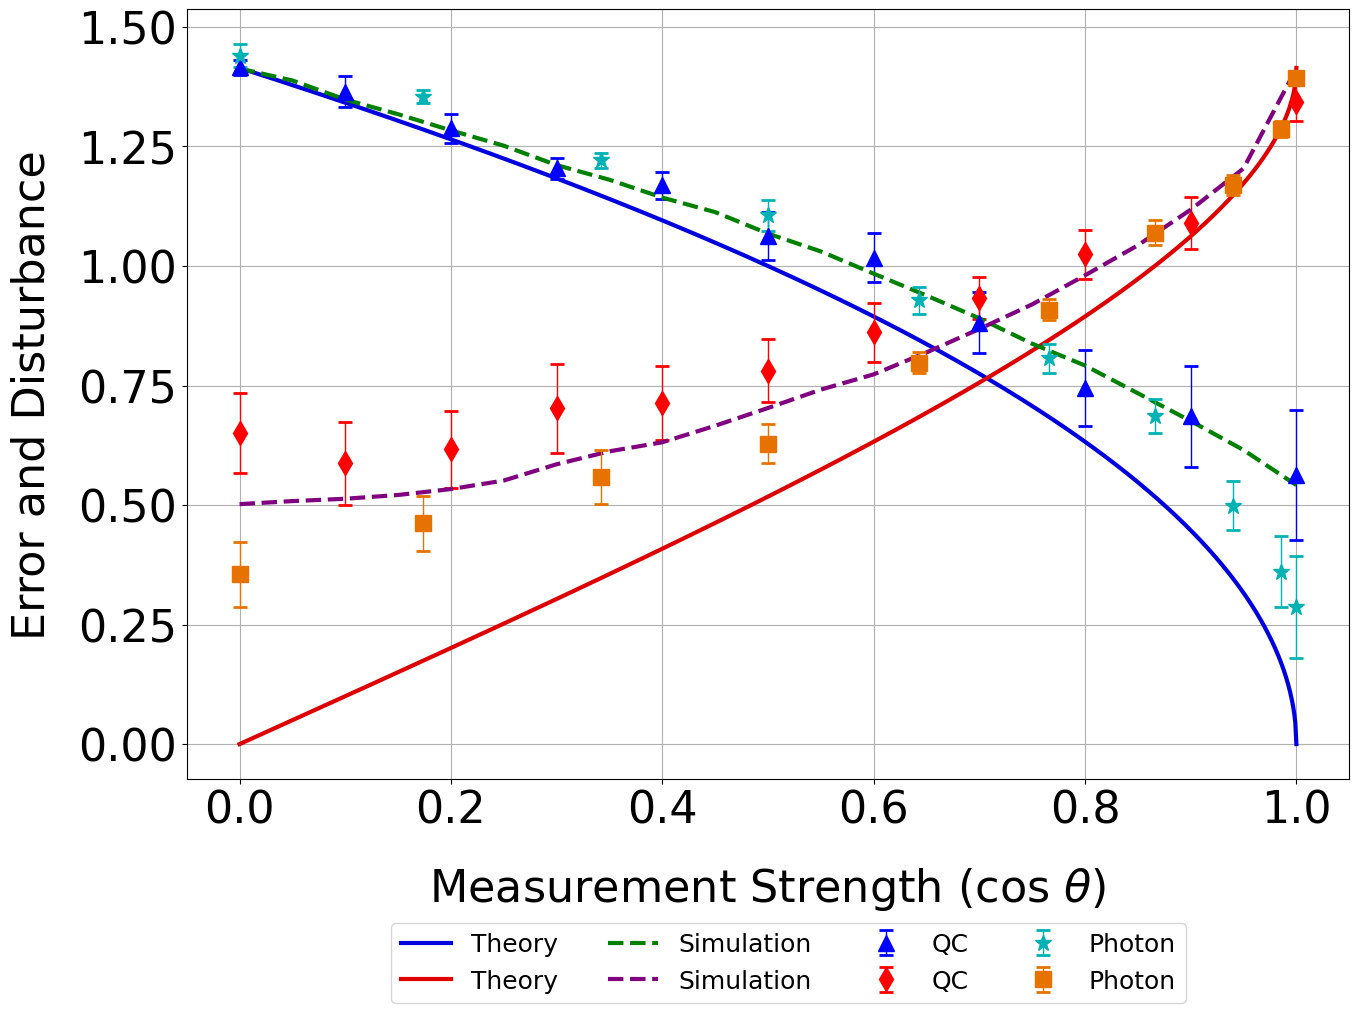

In [41]:
measurement_strength_plot(sim_results, points)

In [11]:
probe_strength = 0.1
groups = 10
shots = 1000000
points = 21

circs = circmake(probe_strength,groups,points,fakebackend)

qnoise_model1 = make_noise_model(0.001,0.001,None)
qnoise_model2 = make_noise_model(0.005,0.005,None)
qnoise_model3 = make_noise_model(0.01,0.01,None)


noise_model_list = [qnoise_model1, qnoise_model2, qnoise_model3]

sim_results = []
for noise_model in noise_model_list:
    
    sim_job = fakebackend.run(circs, noise_model = noise_model ,shots=shots).result()
    raw_error,raw_disturb = get_ed(sim_job)
    sim_results.append(get_plot_data(raw_error,raw_disturb,points))

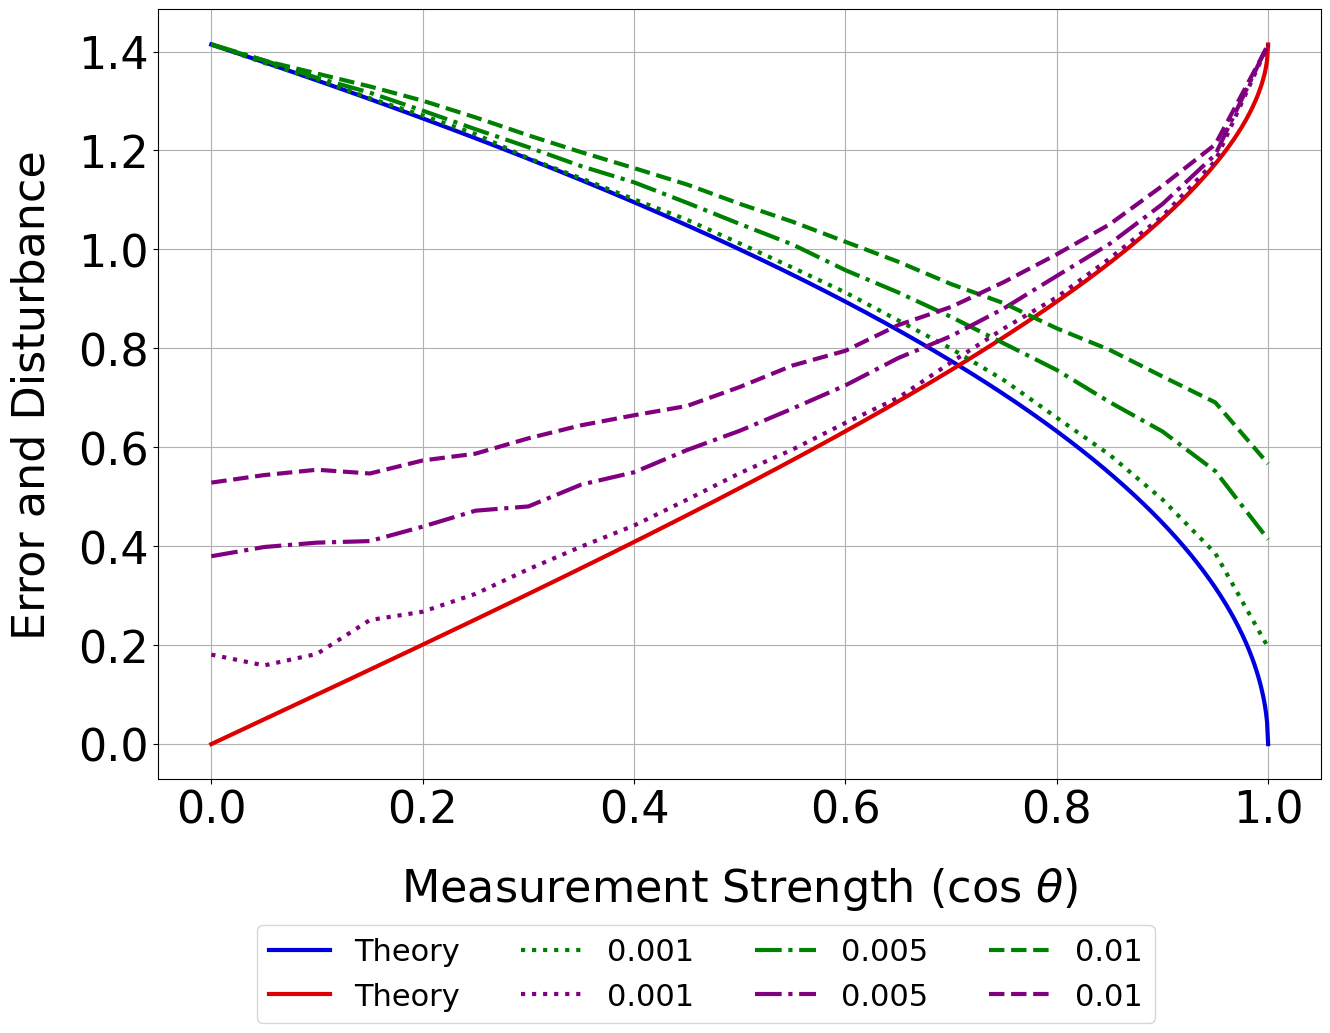

In [15]:
error_simpling_plot(sim_results, points)

In [19]:
probe_strength = 0.1
groups = 10
shots = 1000000
points = 21

circs = circmake(probe_strength,groups,points,fakebackend)

qnoise_model1 = make_noise_model(None,None,[[0.995,0.005],[0.005,0.995]])
qnoise_model2 = make_noise_model(None,None,[[0.99,0.01],[0.01,0.99]])
qnoise_model3 = make_noise_model(None,None,[[0.95,0.05],[0.05,0.95]])


noise_model_list = [qnoise_model1, qnoise_model2, qnoise_model3]

sim_results = []
for noise_model in noise_model_list:
    
    sim_job = fakebackend.run(circs, noise_model = noise_model ,shots=shots).result()
    raw_error,raw_disturb = get_ed(sim_job)
    sim_results.append(get_plot_data(raw_error,raw_disturb,points))

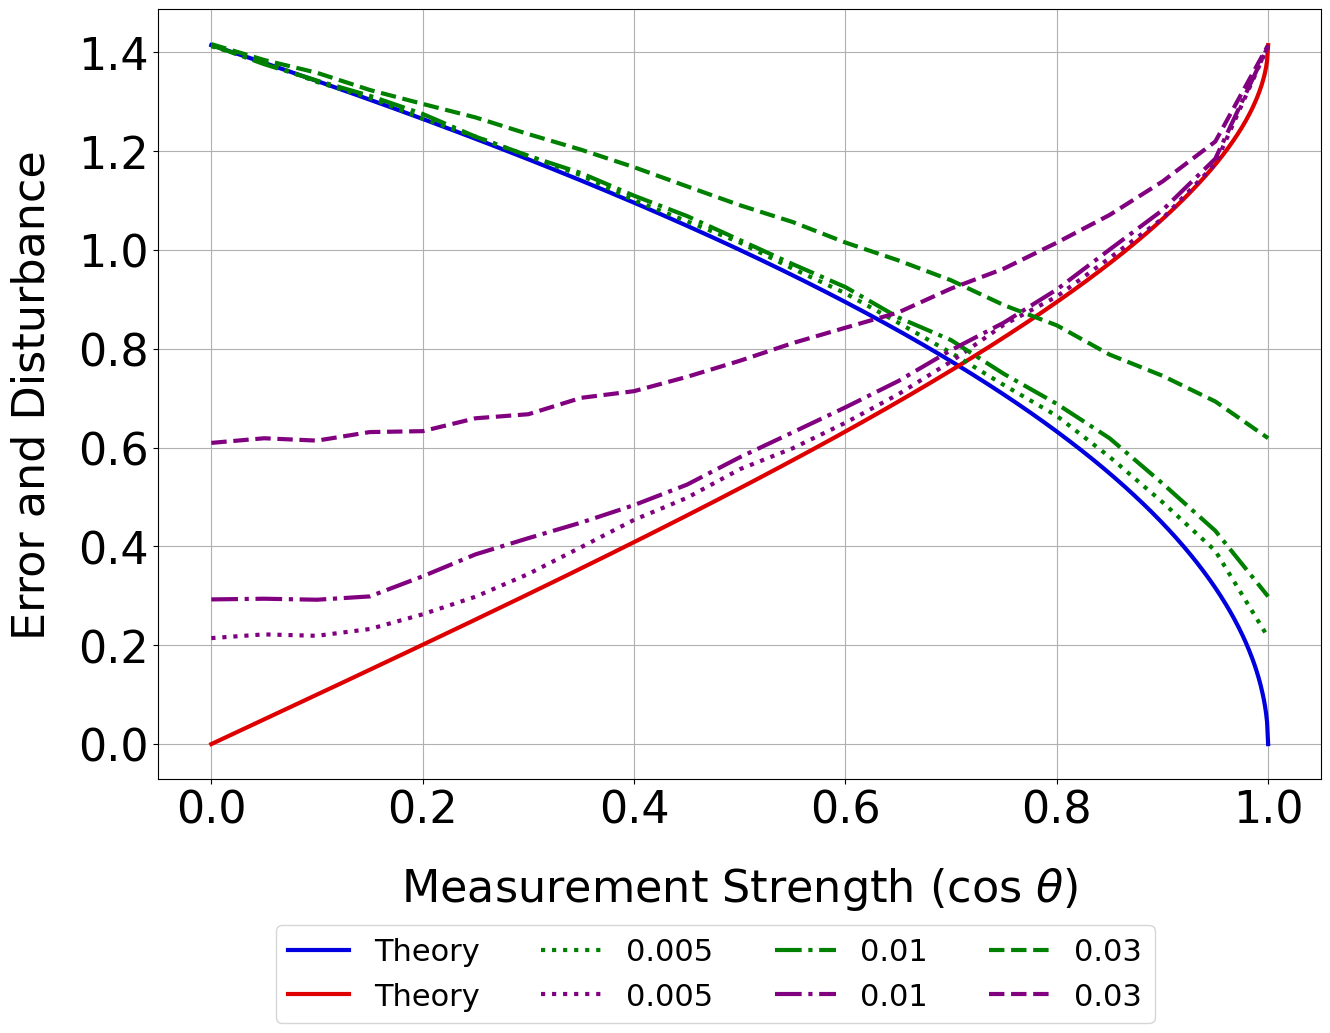

In [20]:
error_simpling_plot(sim_results, points)

In [33]:
probe_strength = 0.1
groups = 10
shots = 1000000
points = 21

circs = circmake(probe_strength,groups,points,fakebackend)

qnoise_model1 = make_phase_amplitudead(0.005,0)
qnoise_model2 = make_phase_amplitudead(0.01,0)
qnoise_model3 = make_phase_amplitudead(0.05,0)


noise_model_list = [qnoise_model1, qnoise_model2, qnoise_model3]

sim_results = []
for noise_model in noise_model_list:
    
    sim_job = fakebackend.run(circs, noise_model = noise_model ,shots=shots).result()
    raw_error,raw_disturb = get_ed(sim_job)
    sim_results.append(get_plot_data(raw_error,raw_disturb,points))

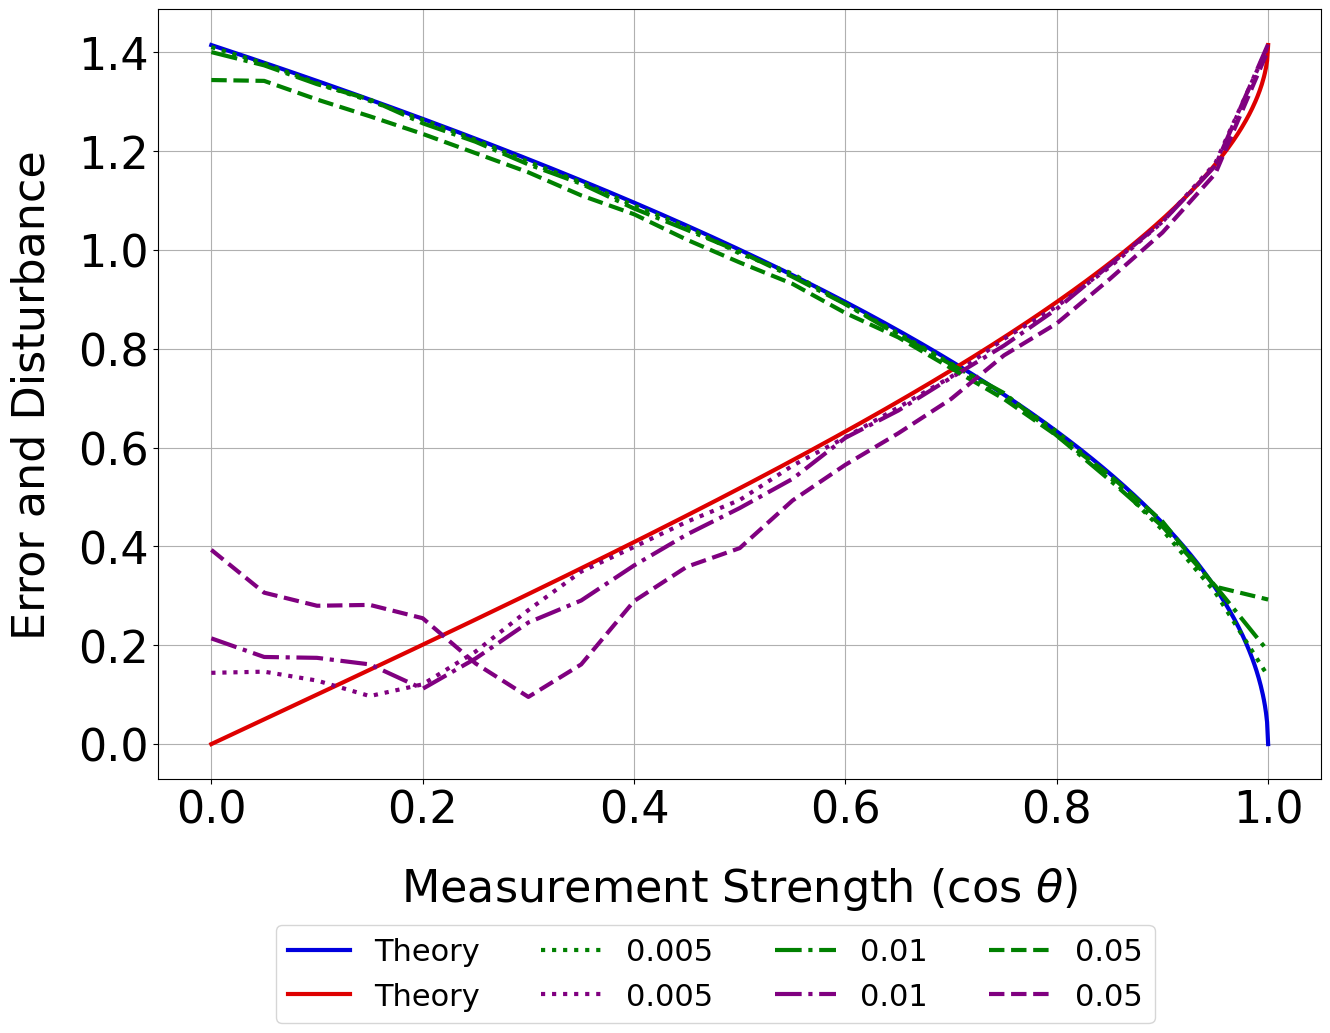

In [34]:
error_simpling_plot(sim_results, points)

In [37]:
probe_strength = 0.1
groups = 10
shots = 1000000
points = 21

circs = circmake(probe_strength,groups,points,fakebackend)

qnoise_model1 = make_phase_amplitudead(0,0.005)
qnoise_model2 = make_phase_amplitudead(0,0.01)
qnoise_model3 = make_phase_amplitudead(0,0.02)


noise_model_list = [qnoise_model1, qnoise_model2, qnoise_model3]

sim_results = []
for noise_model in noise_model_list:
    
    sim_job = fakebackend.run(circs, noise_model = noise_model ,shots=shots).result()
    raw_error,raw_disturb = get_ed(sim_job)
    sim_results.append(get_plot_data(raw_error,raw_disturb,points))

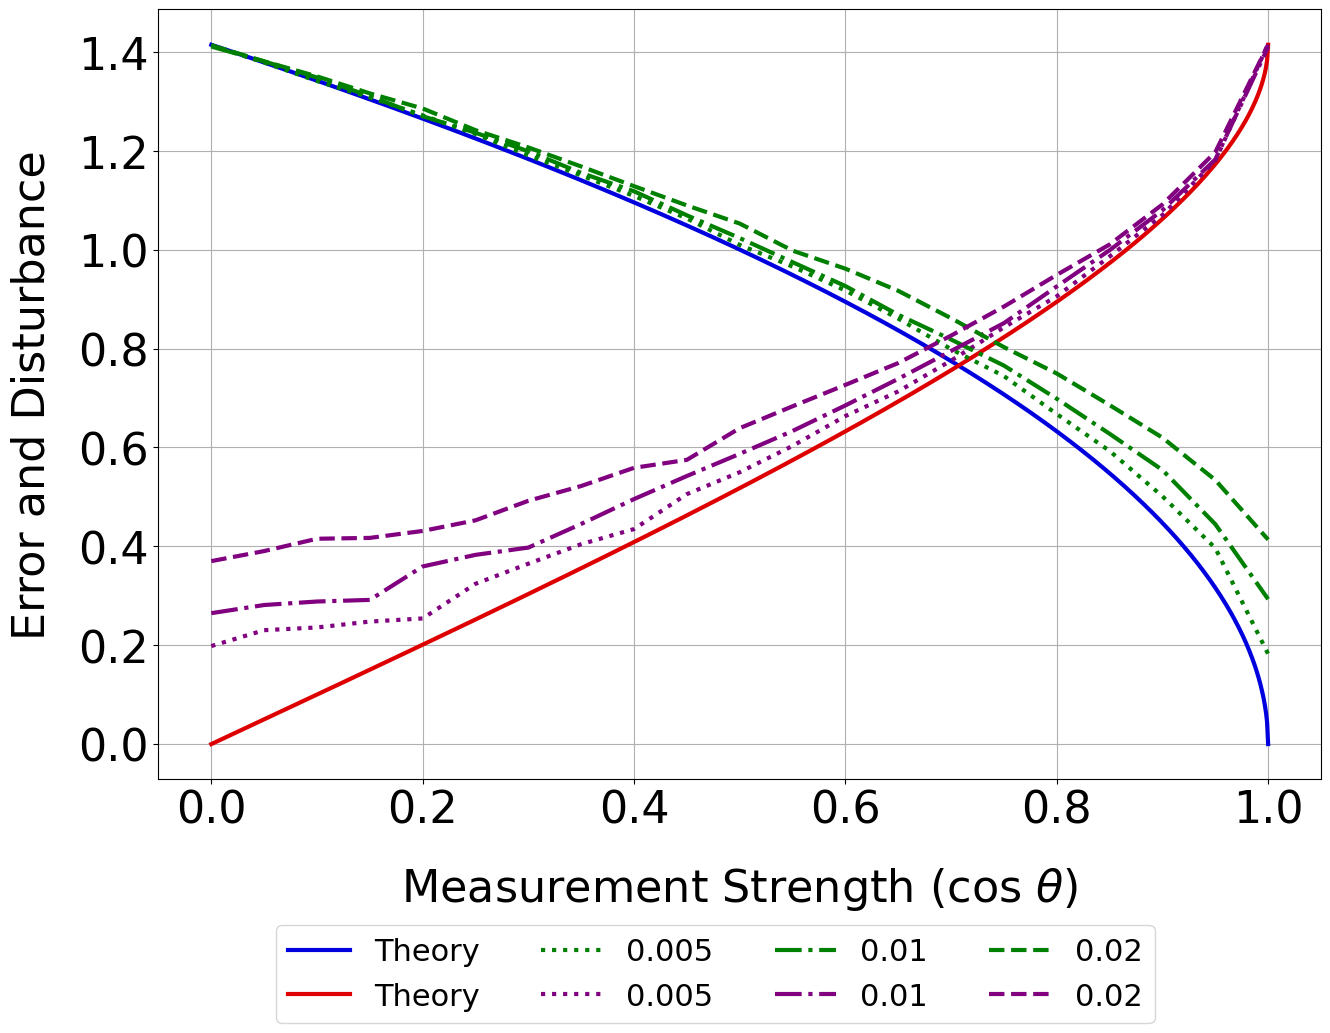

In [38]:
error_simpling_plot(sim_results, points)